In [6]:
import cv2, matplotlib, scipy.ndimage, numba
import numpy as np
import numpy.linalg as npMat
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipyfilechooser import FileChooser
from IPython.display import display

import sys, os, time


# Visualization

The data should be saved in a general form (like `xml` or `panda binary file` or `numpy compressed`), but there we use separate csv file instead (where shape is `600 * 400`).

Make sure that `kernel.csv`, `result.csv` is placed under the same folder of the notebook. 

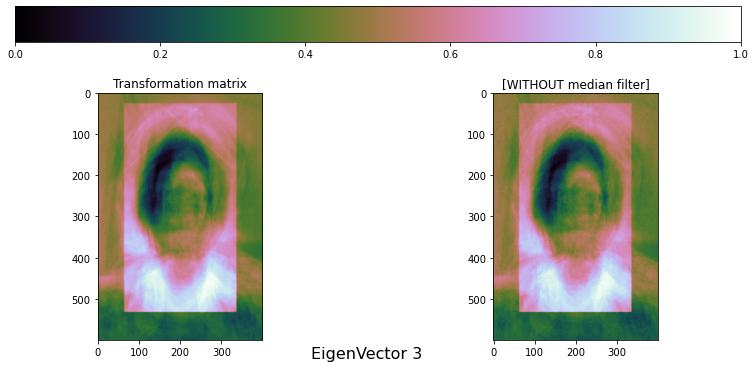

Output()

In [7]:
# shapeOriginal = [600, 400]  # identical to kernel.csv's original shape. now in `utils`
# read train data (format as `pMat/coeff, eNorVec/score, eVal/latent = pca()` in Matlab, with `utils`)
npDict= np.load("train.npz")
kValue, kernel, trainData, utils = npDict['eVal'], npDict['eNorVec'], npDict['pMat'], npDict['utils']
utilsLink = utils[:, 1].T # Specify

# read another data to compare.
try:
    contrastKernel = np.load("train.nomedian.npz")
    if not isinstance(contrastKernel, np.ndarray):
        contrastTrainData = contrastKernel['pMat']
        contrastKernel = contrastKernel['eNorVec']
except Exception:
    contrastKernel = np.zeros((kernel.shape[0], kernel.shape[1]))

def imshowShape(ySelect, cmapString = "cubehelix"):
    try:
        plt.figure(figsize=(13, 10)) # define a figure
        plt.figtext(.5, .1, "EigenVector {}".format(ySelect), fontsize=16, ha="center")

        # https://matplotlib.org/stable/tutorials/colors/colorbar_only.html and https://stackoverflow.com/questions/16595138/standalone-colorbar-matplotlib
        plt.subplot(2, 1, 1) # horizontal plot area for colorbar
        plt.gca().set_visible(False) # ADD to ANY empty plot figure to omit empty output
        plt.colorbar(plt.cm.ScalarMappable(cmap=plt.get_cmap(cmapString)), orientation = "horizontal")

        plt.subplot(2, 2, 3) # area for kernel/Transformation matrix
        plt.imshow(kernel[:, ySelect].reshape((utils[0, 2], utils[0, 3])), cmap=plt.get_cmap(cmapString))
        plt.title("Transformation matrix")

        plt.subplot(2, 2, 4) # area for compare data
        plt.imshow(contrastKernel[:, ySelect].reshape((600, 400)), cmap=plt.get_cmap(cmapString))
        plt.title("[WITHOUT median filter]")
    except ValueError as e:
        print("Input your cmapString, e.g. `cubehelix`?\nPython report ValueError: {}".format(e))

imshowShape(3) # print figure per eigenVector
# or an interactive figure
ui0_0 = widgets.IntSlider(min=0, max=min(kernel.shape[1], contrastKernel.shape[1]) - 1,
    step=1, value=20, description="Which eigenvector?")
ui0_1 = widgets.Text(value="cubehelix", description="Color Map:")
ui0 = widgets.HBox([ui0_0, ui0_1])
output0 = widgets.interactive_output(imshowShape, {'ySelect': ui0_0, 'cmapString': ui0_1})
display(ui0, output0) # See <https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html#More-control-over-the-user-interface:-interactive_output>

# Classifier


In [8]:
def cropTestMatrix(imageMatrix): # used by readFromWebCallback
    # cv2.resize(imageMatrix)
    pass

import hw1, hw2
def readFromPath(pathFromWidgets, hw1Var = 1, hw2Var = 1): # like class1.ipynb#block2
    try:
        imMatrix = cv2.imread(pathFromWidgets) # read testdata from file
        imMatrix = hw1.colorSpaceMatrix(BGR = imMatrix).space[hw1Var] # default: Convert to Grey with weighted mean.
        imMatrix = hw2.hw2Config[hw2Var](imMatrix) # default: With the process of Median Filter
        if imMatrix.shape[0] != utils[0][2] or imMatrix.shape[1] != utils[0][3]:
            raise IndexError("Shape dismatch.")
        return imMatrix.flatten('C') # flatten like reshape, row-major order
    except Exception as e:
        print("Error when read {}: {}".format(pathFromWidgets, e))
        return False


def readFromWebCallback(rawRtcStream):
    pass

def processMatrix(imageMatrix):
    # per kernel's k(y axis), dot product of imageMatrix and kernel[:, k]
    # See more <https://ajcr.net/Basic-guide-to-einsum/> @cite ajcr_2015
    # return np.einsum("i,ik->k", imageMatrix, contrastKernel) # TODO contrast
    return np.einsum("i,ik->k", imageMatrix, kernel)

@numba.jit(nopython=True)
def classifyKnn(imageFeature, calcAmount: int, kNum: int):
    '''This function use an O(nm) easiest way to implement the search of each
    scan data's k nearest neighbor.
    
    With numba.jit(nopython=True)
    '''
    if calcAmount > kernel.shape[0] :
        raise IndexError("arg Dimension can't exceed kernel's shape[0].")
    returnList = [[0.0, 0, 0] for i in range(utils[-1, 1])] # DO NOT use [[]] * calcAmount in numba
    for i in range(utils[-1, 1]): # utils[-1][1] indicates the largest number of dataset image
        # returnList[i][0] = npMat.norm(imageFeature[: calcAmount] - contrastTrainData[i, : calcAmount]) # TODO contrast
        returnList[i][0] = npMat.norm(imageFeature[: calcAmount] - trainData[i, : calcAmount]) # euler's distance
        returnList[i][1] = i # the corresponding dataset image
        returnList[i][2] = utils[np.searchsorted(utilsLink, i)][0] # the corresponding face
    returnList.sort(reverse=False) # sorted by [0]: euler's distance

    resultList = np.array(returnList, dtype=np.int64)[: kNum, 2] # extract kNN's face number
    resultMiddle = np.bincount(resultList) # count the occurrence of each number, and save them with their number index
    result = np.argwhere(resultMiddle == resultMiddle.max())[0] # NN in k range
    while result.size != 1: # if multiple NN in k range, shrink the range by 1
        kNum -= 1
        resultMiddle[resultList[kNum]] -= 1
        result = np.argwhere(resultMiddle == resultMiddle.max())[0]

    return returnList, result[0]

# %timeit classifyKnn(np.array([0 for i in range(kernel.shape[1])]), 40, 10)

In [9]:
testFeature = []
for count0, i in enumerate(utils):
    imWait = readFromPath("./dataset/test/s{}_11.jpg".format(i[0], i[0]))
    if not isinstance(imWait, bool):
        testFeature.append([processMatrix(imWait), i[0]])

Error when read ./dataset/test/s25_11.jpg: axis 2 is out of bounds for array of dimension 0
Error when read ./dataset/test/s27_11.jpg: axis 2 is out of bounds for array of dimension 0


# Result
cross-walks of test dataset v.s. feature dataset.

In [10]:
for i in range(20):
    a, b=classifyKnn(testFeature[i][0], 13, 7)
    if testFeature[i][1] != b:
        print(testFeature[i][1], b, np.array(a)[:3])


13 12 [[1.50075668e+04 1.75000000e+02 2.30000000e+01]
 [1.74288648e+04 1.00000000e+02 1.10000000e+01]
 [1.75567168e+04 1.01000000e+02 1.20000000e+01]]
